In [10]:
import json
import pathlib
import matplotlib.pyplot as plt
import re
import pickle

In [6]:
result_dir = pathlib.Path("/mnt/data/pix2pix/result_dir/label2photo/result_1/")
assert result_dir.exists()

In [12]:
def load_log_opt(seed, root_result_dir):
    """
    log と opt を読み込む＆loss_filter を作成

    Args:
        seed (int): seed
        root_result_dir (PosixPath): /mnt/data/fashion550k/result_dir/{0}/result_{1}/".format(name, n) など

    Returns:
        log, loss_filter
    """
    num = re.search("[0-9]+", root_result_dir.stem).group()
    result_dir = root_result_dir / "result_{0}_{1}".format(num, seed)
    assert result_dir.exists(), "{} is not Found".format(result_dir)

    log_json_path = result_dir / "log/log.json"
    with open(log_json_path) as f:
        log = json.load(f)
    with open(result_dir / "args.pickle", "rb") as f:
        opt = pickle.load(f)
        if num == "14":
            opt.no_l1loss = False
            opt.no_fmloss = True
            opt.no_ploss = True
    loss_filter = {
        "d_real": True,
        "d_fake": True,
        "g_gan": True,
        "g_l1": not opt.no_l1loss,
    }
    return log, opt, loss_filter

def storing_loss(log, opt, loss_filter):
    """
    GANLoss, FMLoss, PLoss を格納する関数
    Args:
        log (json): log
        opt : option
        loss_filter (dict): loss_filter

    Raises:
        KeyError: [description]

    Returns:
        loss_dict : loss が格納されたdict
    """

    loss_dict = {
        "d_real": [],
        "d_fake": [],
        "g_gan": [],
        "g_l1": [],
    }
    # ロスを格納
    for key, value in loss_filter.items():
        if key == "d_real" and value:
            for epoch in range(1, opt.epoch + 1):
                loss_dict["d_real"].append(
                    log["epoch_{}".format(epoch)]["train_dis_loss"]["d_real"]
                )
        elif key == "d_fake" and value:
            for epoch in range(1, opt.epoch + 1):
                loss_dict["d_fake"].append(
                    log["epoch_{}".format(epoch)]["train_dis_loss"]["d_fake"]
                )
        elif key == "g_gan" and value:
            for epoch in range(1, opt.epoch + 1):
                loss_dict["g_gan"].append(
                    log["epoch_{}".format(epoch)]["train_gen_loss"]["g_gan"]
                )
        elif key == "g_l1" and value:
            for epoch in range(1, opt.epoch + 1):
                loss_dict["g_l1"].append(
                    log["epoch_{}".format(epoch)]["train_gen_loss"]["g_l1"]
                )
        elif value:
            raise KeyError("実装されていない. Got {}".format(key))

    return loss_dict

In [18]:
log, opt, loss_fillter = load_log_opt(1, result_dir)
loss_dict = storing_loss(log, opt, loss_fillter)

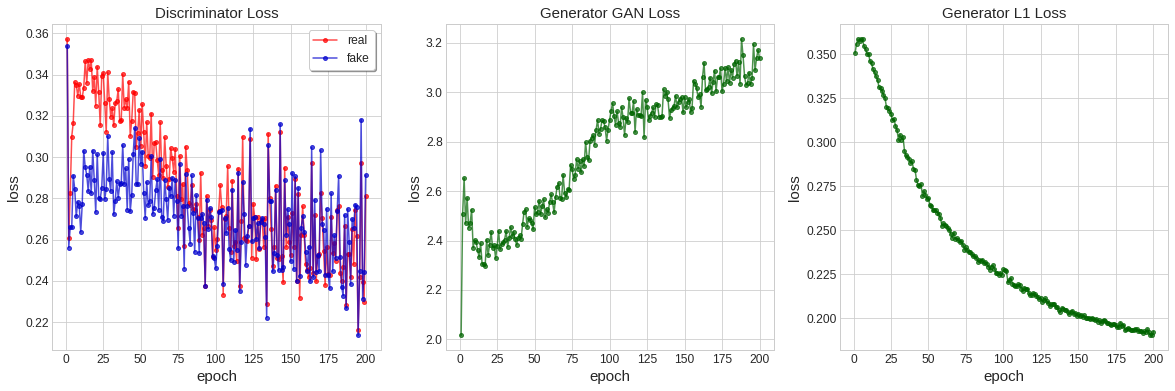

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
plt.style.use("seaborn-whitegrid")
epoch = range(1, opt.epoch + 1)
colors = [["red", "mediumblue"], "darkgreen", "darkgreen"]
alpha = 0.7
for loss_name, ax, color in zip(["d", "g_gan", "g_l1"], axes.flatten(),
                                colors):
    if loss_name == "d":
        ax.plot(epoch,
                loss_dict["d_real"],
                color=color[0],
                marker="o",
                ms=4,
                alpha=alpha,
                label="real")
        ax.plot(epoch,
                loss_dict["d_fake"],
                color=color[1],
                marker="o",
                label="fake",
                ms=4,
                alpha=alpha)
    else:
        ax.plot(epoch,
                loss_dict[loss_name],
                color=color,
                marker="o",
                ms=4,
                alpha=alpha)
    ax.set_ylabel("loss", fontsize=15)
    ax.set_xlabel("epoch", fontsize=15)
    ax.tick_params(labelsize=12)
    if loss_name == "d":
        ax.legend(frameon=True, shadow=True, fontsize=12)
    if loss_name == "d":
        title = "Discriminator Loss"
    elif loss_name == "g_gan":
        title = "Generator GAN Loss"
    else:
        title = "Generator L1 Loss"
    ax.set_title(title, fontsize=15)
fig.savefig(result_dir / "r_{}_{}_loss.png".format(opt.num, opt.seed),
        bbox_inches='tight',
        pad_inches=0)